<a href="https://colab.research.google.com/github/wkotala/DNN-HW1/blob/main/DNN-homework-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project: Multitask Learning for Geometric Shape Classification and Counting**

# Setup

In [1]:
!wget  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
!unzip -o data_gsn.zip &> /dev/null
!rm data_gsn.zip

--2025-11-25 17:51:51--  https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip [following]
--2025-11-25 17:51:51--  https://raw.githubusercontent.com/marcin119a/data/refs/heads/main/data_gsn.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5544261 (5.3M) [application/zip]
Saving to: ‘data_gsn.zip’

data_gsn.zip        100%[===================>]   5.29M  --.-KB/s    in 0.06s   

2025-11-25 17:51:52 (87.9 MB/s) - ‘data_gsn.zip’ saved [5544261/5544261]



In [2]:
!pip install -q torch torchvision matplotlib numpy pandas plotly Pillow ipython torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.3 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import sys
import plotly.graph_objects as go
import plotly.express as px

from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass, replace
from typing import Callable, Type
from plotly.subplots import make_subplots
from IPython.display import display
from enum import Enum
from math import isnan
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassF1Score

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()

torch.manual_seed(1)

# Exploratory Data Analysis

In [4]:
data_dir = Path('data')
labels_df = pd.read_csv(data_dir / 'labels.csv')
labels_df

,name,squares,circles,up,right,down,left
0,img_00000.png,0,0,4,0,6,0
1,img_00001.png,0,0,0,5,0,5
2,img_00002.png,0,0,8,0,2,0
3,img_00003.png,0,7,0,0,0,3
4,img_00004.png,0,0,3,0,0,7
...,...,...,...,...,...,...,...
9995,img_09995.png,3,0,7,0,0,0
9996,img_09996.png,8,0,2,0,0,0
9997,img_09997.png,8,0,0,0,0,2
9998,img_09998.png,6,0,0,4,0,0


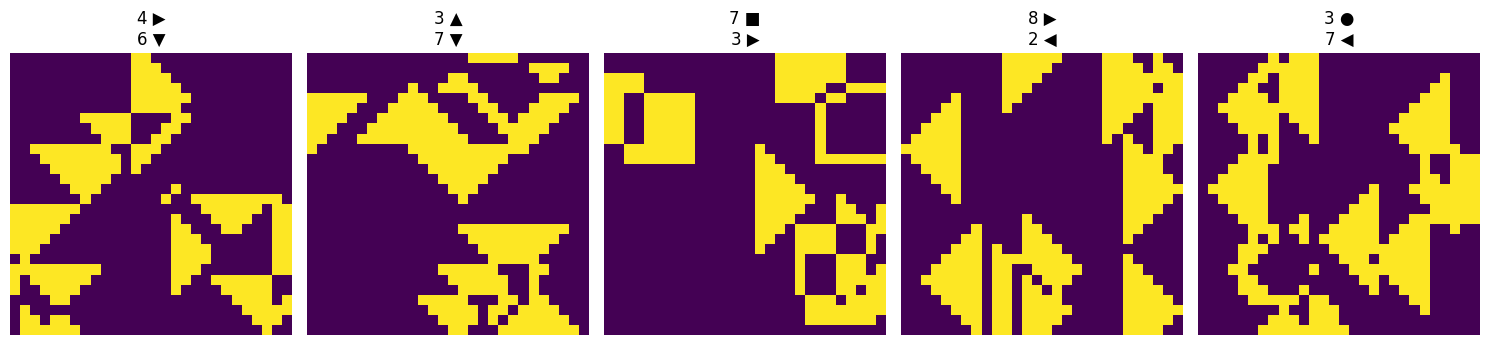

In [5]:
sample_df = labels_df[10:15]
shapes = {
    'squares': '\u25A0',
    'circles': '\u25CF',
    'up': '\u25B2',
    'right': '\u25B6',
    'down': '\u25BC',
    'left': '\u25C0',
}

fig, axes = plt.subplots(1, len(sample_df), figsize=(15, 4))

for ax, row in zip(axes, sample_df.itertuples()):
    # Plot the image.
    img_path = data_dir / row.name
    img = Image.open(img_path).convert('L')
    ax.imshow(img)

    # Display info about shapes in the image.
    title_parts = [
        f'{count} {shape_symbol}'
        for shape_name, shape_symbol in shapes.items()
        if (count := getattr(row, shape_name)) > 0
    ]
    ax.set_title('\n'.join(title_parts))
    ax.axis('off')

plt.tight_layout()
plt.show()

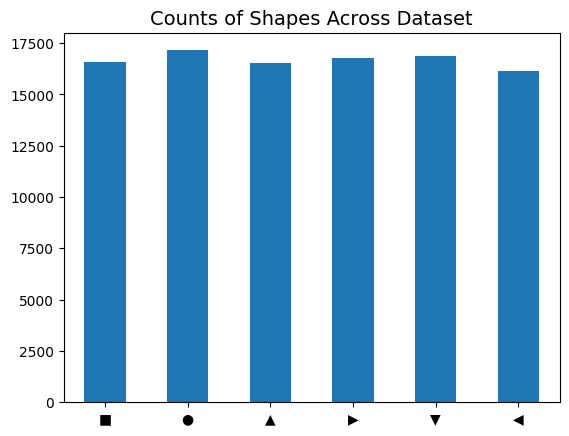

In [6]:
plt.title('Counts of Shapes Across Dataset', fontsize=14)
labels_df.drop('name', axis=1).sum().rename(shapes).plot.bar(rot=0)
plt.show()

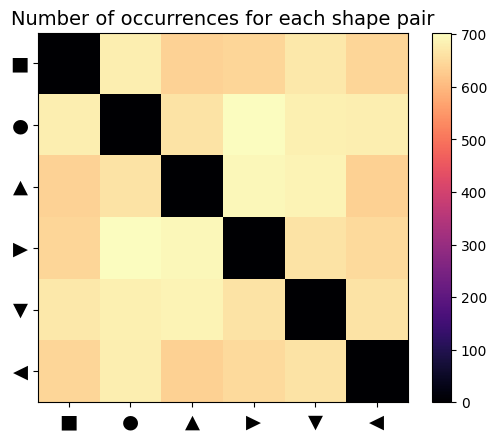

In [7]:
occurrence = (labels_df.drop('name', axis=1) > 0).astype(int)
co_occurrence = occurrence.T @ occurrence
for i in range(len(co_occurrence)):
    co_occurrence.iat[i,i] = 0

# Draw a heatmap.
plt.title('Number of occurrences for each shape pair', fontsize=14)
plt.imshow(co_occurrence, cmap='magma')
plt.colorbar()

# Label the axes.
tick_positions = np.arange(len(co_occurrence.columns))
tick_labels = [shapes[name] for name in co_occurrence.columns]
plt.xticks(tick_positions, tick_labels, fontsize=14)
plt.yticks(tick_positions, tick_labels, fontsize=14, va='center')

plt.show()

Classes in Train Dataset:       105/135
Classes in Validation Dataset:  105/135
All val classes exist in train? True


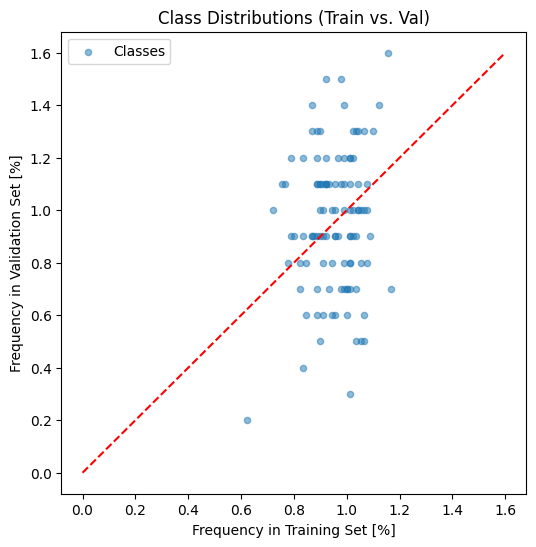

In [8]:
train, val = labels_df.drop('name', axis=1).iloc[:9000], labels_df.drop('name', axis=1).iloc[9000:]

train_counts = train.value_counts(normalize=True) * 100 # convert to %
val_counts = val.value_counts(normalize=True) * 100 # convert to %

# Check coverage
print(f"Classes in Train Dataset:       {len(train_counts)}/135")
print(f"Classes in Validation Dataset:  {len(val_counts)}/135")
print(f"All val classes exist in train? {val_counts.index.isin(train_counts.index).all()}")

# Plot
df = pd.DataFrame({'Train': train_counts, 'Val': val_counts}).fillna(0)

plt.figure(figsize=(6, 6))
plt.scatter(df['Train'], df['Val'], alpha=0.5, label='Classes', s=20)
plt.plot([0, df.max().max()], [0, df.max().max()], 'r--')
plt.xlabel('Frequency in Training Set [%]')
plt.ylabel('Frequency in Validation Set [%]')
plt.title('Class Distributions (Train vs. Val)')
plt.legend()
plt.show()

# Data pipeline

## Augmentations

In [9]:
class RandomTransformator:
    """
    Assumes shapes are in order: squares, circles, up, right, down, left.
    """

    def __call__(self, img: Tensor, counts: Tensor) -> tuple[Tensor, Tensor]:
        """ Performs random transformations. """
        img, counts = self.horizontal_flip(img, counts, p=0.5)
        img, counts = self.vertical_flip(img, counts, p=0.5)
        img, counts = self.rotation(img, counts)
        return img, counts

    def horizontal_flip(self, img: Tensor, counts: Tensor, p: float = 1) -> tuple[Tensor, Tensor]:
        """ Flips image horizontally with probability = p """
        if torch.rand(1) < p:
            img = img.flip(2)
            counts[3], counts[5] = counts[5].item(), counts[3].item()

        return img, counts

    def vertical_flip(self, img: Tensor, counts: Tensor, p: float = 1) -> tuple[Tensor, Tensor]:
        """ Flips image vertically with probability = p """
        if torch.rand(1) < p:
            img = img.flip(1)
            counts[2], counts[4] = counts[4].item(), counts[2].item()

        return img, counts

    def rotation(self, img: Tensor, counts: Tensor) -> tuple[Tensor, Tensor]:
        """ Rotates image by random angle from: 0, pi/2, pi, -pi/2 """
        k = torch.randint(-1, 3, size=(1,)).item()
        img = img.rot90(k=k, dims=(1,2))

        triangles_shifted = torch.roll(counts[2:], -k)
        counts[2:] = triangles_shifted

        return img, counts

## Dataset

In [10]:
class GSNDataset(Dataset):
    """
    Custom PyTorch Dataset for the Geometric Shape Numbers (GSN) dataset.

    GSNDataset handles two tasks:
    1. Classification: Identifying which of the 135 possible shape-pair
       and count-split configurations is present in the image.
    2. Regression: Predicting the count of 6 different shape types.
    """

    def __init__(self, data_dir: Path, train: bool, train_val_split: float = 0.9, transform: Callable | None = None):
        """
        Input:
        - data_dir: Path to the directory containing 'labels.csv' and all the images.
        - train: A boolean indicating whether to create train or validation dataset.
        - train_val_split: Fraction specifying what percentage of data is train data; the rest is validation data.
        - transform: Optional transform to be applied on a sample.
                     transform should implement __call__(image, counts) -> (transformed_image, transformed_counts),
                     where images is a tensor of shape (C=1, H=28, W=28),
                     and counts is a tensor of shape (6,), with count of shapes in the same order as in self.shape_names()
        """
        self.data_dir = data_dir
        self.transform = transform

        all_labels_df = pd.read_csv(data_dir / 'labels.csv')
        train_len = round(len(all_labels_df) * train_val_split)

        if train:
            self.labels_df = all_labels_df[:train_len].reset_index(drop=True)
        else:
            self.labels_df = all_labels_df[train_len:].reset_index(drop=True)

        self.shape_columns = list(self.labels_df.drop('name', axis=1).columns)
        self.ensure_expected_shapes_order()

        self._pair_to_id = dict()
        pair_id = 0
        for i in range(len(self.shape_columns)):
            for j in range(i + 1, len(self.shape_columns)):
                self._pair_to_id[(i, j)] = pair_id
                pair_id += 1

    def ensure_expected_shapes_order(self):
        expected_shapes_order = ['squares', 'circles', 'up', 'right', 'down', 'left']
        if self.shape_columns != expected_shapes_order:
            self.labels_df = self.labels_df[['name'] + expected_shapes_order]
            self.shape_columns = expected_shapes_order

    def shape_names(self) -> list[str]:
        """
        Returns list of shape names used in dataset.
        Order of the shapes in this list dictates:
        - Order of count labels for regression model.
        - Class labels for classification model:
            - classes 0...8 contain shapes list[0], list[1]
            - classes 9...17 contain shapes list[0], list[2],
            ...
            - classes 36...44 contain shapes list[0], list[5],
            - classes 45...53 contain shapes list[1], list[2],
            ...
            - classes 126...134 contain shapes list[4], list[5].
        """
        return self.shape_columns

    def _calculate_class_from_shapes_counts(self, counts: Tensor) -> Tensor:
        """
        Translates shape configurations into unique class labels.

        Input: counts of each shape in an image as tensor of shape (6,)
        Output: class label, i.e. integer in [0, 134], as Tensor
        """
        nonzero_indices = torch.nonzero(counts, as_tuple=True)[0]
        assert len(nonzero_indices) == 2
        assert counts[nonzero_indices].sum() == 10

        pair = tuple(nonzero_indices.tolist())
        assert pair in self._pair_to_id
        return self._pair_to_id[pair] * 9 + counts[pair[0]] - 1

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx: int) -> tuple[Tensor, Tensor, Tensor]:
        """
        Output:
        - image as tensor of shape (C=1, H=28, W=28)
        - class label as tensor of shape (1,)
        - true counts as tensor of shape (6,)
        """
        row = self.labels_df.iloc[idx]
        img_path = self.data_dir / row['name']
        img = Image.open(img_path).convert('L')
        img_tensor = transforms.functional.to_tensor(img)

        counts = torch.tensor(row[self.shape_columns].astype(np.float32).to_numpy(), dtype=torch.float32)

        if self.transform:
            img_tensor, counts = self.transform(img_tensor, counts)

        class_label = self._calculate_class_from_shapes_counts(counts).to(torch.long)

        return img_tensor, class_label, counts

# Model architecture

In [11]:
class MultitaskModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(), # (B, 8, H, W)
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(), # (B, 16, H, W)
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(), # (B, 32, H, W)
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(), # (B, 64, H, W)
            nn.Flatten(start_dim=1), # (B, 64 * H * W)
            nn.Linear(64 * 28 * 28, 256), nn.ReLU() # (B, 256)
        )

        self.head_cls = nn.Sequential(
            nn.Linear(256, 256), # (B, 256)
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(256, 135), # (B, 135)
            nn.LogSoftmax(dim=1)
        )

        self.head_cnt = nn.Sequential(
            nn.Linear(256, 128), # (B, 128)
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 6), # (B, 6)
        )

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Input shape: (B, 1, H, W).
        Output:
        - classification log-probabilities (B, 135)
        - regression counts (B, 6)
        """
        features = self.backbone(x)
        log_probs = self.head_cls(features)
        counts = self.head_cnt(features)
        return log_probs, counts

# Training & Evaluation

## Setup

In [12]:
@dataclass
class TrainingSettings:
    device: torch.device

    learning_rate: float = 1e-3
    max_epochs: int = 100
    train_batch_size: int = 64

    cls_loss_fn: Callable = F.nll_loss        # classification loss function
    lambda_cls: float = 1.0                   # weight of classification loss function
    cnt_loss_fn: Callable = F.smooth_l1_loss  # regression loss function
    lambda_cnt: float = 1.0                   # weight of regression loss function

    early_stop_patience: int = 10

    optimizer: Type[torch.optim.Optimizer] = torch.optim.Adam

## Evaluation Metrics

In [13]:
class ClassificationMetricsCalculator:
    """
    Calculates classification metrics.
    Each method follows the convention:
    Input:
    - predicted classes as tensor of shape (B,)
    - actual classes as tensor of shape (B,)
    Output:
    - calculated metric as float / 2-dimensional tensor
    """

    def __init__(self):
        self.n_classes = 135
        self.n_classes_per_pair = 9
        self.n_pairs = 15
        self.n_shapes = 6
        assert self.n_classes == self.n_classes_per_pair * self.n_pairs

    def top_1_accuracy(self, pred_class: Tensor, actual_class: Tensor) -> float:
        return (pred_class == actual_class).to(torch.float32).mean().item()

    def macro_f1(self, pred_class: Tensor, actual_class: Tensor) -> float:
        metric = MulticlassF1Score(num_classes=self.n_classes, average='macro').to(pred_class.device)
        f1_score = metric(pred_class, actual_class)
        return f1_score.item()

    def per_pair_accuracy(self, pred_class: Tensor, actual_class: Tensor) -> Tensor:
        """
        Output: tensor of shape (6, 6) where tensor[i, j] is accuracy for pair (i-th shape, j-th shape).
        Order of shapes is as specified in GSNDataset.shape_names.
        """
        per_pair_accuracy = torch.full((self.n_shapes, self.n_shapes), float('nan'), device=pred_class.device)
        pair_id = 0

        pair_id = 0
        for i in range(self.n_shapes):
            for j in range(i + 1, self.n_shapes):
                start_class = pair_id * self.n_classes_per_pair
                end_class = start_class + self.n_classes_per_pair
                mask = (start_class <= actual_class) & (actual_class < end_class)

                if mask.any():
                    acc = self.top_1_accuracy(pred_class[mask], actual_class[mask])
                    per_pair_accuracy[i, j] = acc
                    per_pair_accuracy[j, i] = acc

                pair_id += 1

        return per_pair_accuracy

    def confusion_matrix(self, pred_class: Tensor, actual_class: Tensor) -> Tensor:
        """
        Output:
        - confusion matrix as tensor of shape (135, 135)
        """
        metric = MulticlassConfusionMatrix(num_classes=self.n_classes).to(pred_class.device)
        confusion_matrix = metric(pred_class, actual_class)
        return confusion_matrix


class RegressionMetricsCalculator:
    """
    Calculates regression metrics.
    Each method follows the convention:
    Input:
    - predicted counts as tensor of shape (B, 6)
    - actual counts as tensor of shape (B, 6)
    Output:
    - calculated metric as float / list[float]
    """

    def mae_per_class(self, pred_counts: Tensor, actual_counts: Tensor) -> list[float]:
        absolute_error = torch.abs(pred_counts - actual_counts)
        return absolute_error.mean(dim=0).tolist()

    def mae(self, pred_counts: Tensor, actual_counts: Tensor) -> float:
        absolute_error = torch.abs(pred_counts - actual_counts)
        return absolute_error.mean().item()

    def rmse_per_class(self, pred_counts: Tensor, actual_counts: Tensor) -> list[float]:
        squared_error = torch.square(pred_counts - actual_counts)
        return torch.sqrt(squared_error.mean(dim=0)).tolist()

    def rmse(self, pred_counts: Tensor, actual_counts: Tensor) -> float:
        squared_error = torch.square(pred_counts - actual_counts)
        return torch.sqrt(squared_error.mean()).item()


class MetricsCalculator:
    def __init__(self):
        self.cls = ClassificationMetricsCalculator()
        self.cnt = RegressionMetricsCalculator()

    def all_metrics(self, pred_class: Tensor, actual_class: Tensor, pred_counts: Tensor, actual_counts: Tensor) -> Callable[[], dict]:
        """
        Returns a closure.
        Call it to actually perform the calculation of metrics.
        """
        pred_class = pred_class.detach()
        actual_class = actual_class.detach()
        pred_counts = pred_counts.detach()
        actual_counts = actual_counts.detach()

        return lambda: {
            'acc': self.cls.top_1_accuracy(pred_class, actual_class),
            'f1': self.cls.macro_f1(pred_class, actual_class),
            'per_pair_acc': self.cls.per_pair_accuracy(pred_class, actual_class),
            'conf': self.cls.confusion_matrix(pred_class, actual_class),

            'mae': self.cnt.mae(pred_counts, actual_counts),
            'mae_per_class': self.cnt.mae_per_class(pred_counts, actual_counts),
            'rmse': self.cnt.rmse(pred_counts, actual_counts),
            'rmse_per_class': self.cnt.rmse_per_class(pred_counts, actual_counts),
        }

## Visualization & Reporting

In [14]:
class TraceName(str, Enum):
    TRAIN_CLS = 'train cls loss'
    TRAIN_CNT = 'train cnt loss'

    VAL_CLS = 'val cls loss'
    VAL_CNT = 'val cnt los'
    VAL_ACC = 'val accuracy'
    VAL_RMSE = 'val RMSE'

class TrainingVisualizer:
    def __init__(self, dashboard_title: str):
        """
            Defines layout of the training dashboard and displays empty plots.
        """

        # Data that will be visualized.
        self.data = {trace_name: [] for trace_name in TraceName}

        # Layout.
        plots = make_subplots(
            rows=2, cols=3,
            specs=[[{'colspan': 3}, None, None],
                   [{}, {}, {}]],
            subplot_titles=('Training Loss', 'Validation Loss', 'Validation Accuracy', 'Validation RMSE'),
        ).update_layout(
            template='plotly_dark',
            height=800,
            title_text=dashboard_title,
            hovermode='x unified',
            title_font_size=22,
        )

        plots.update_xaxes(title_text='Epoch')
        plots.update_yaxes(title_text='Loss Value', col=1)
        plots.update_yaxes(title_text='Accuracy %', row=2, col=2)
        plots.update_yaxes(title_text='RMSE Value', row=2, col=3)

        # Traces.
        train_losses_pos = {'row': 1, 'col': 1}
        val_losses_pos = {'row': 2, 'col': 1}

        traces_config = [ # list  of tuples (name, position, stackgroup)
            (TraceName.TRAIN_CLS, train_losses_pos, 'train'),
            (TraceName.TRAIN_CNT, train_losses_pos, 'train'),
            (TraceName.VAL_CLS, val_losses_pos, 'val'),
            (TraceName.VAL_CNT, val_losses_pos, 'val'),
            (TraceName.VAL_ACC, {'row': 2, 'col': 2}, None),
            (TraceName.VAL_RMSE, {'row': 2, 'col': 3}, None)
        ]

        for name, pos, stackgroup in traces_config:
            plots.add_trace(go.Scatter(name=name, stackgroup=stackgroup), **pos)

        # Display the plots as widget that will be updated each epoch.
        self.plots = go.FigureWidget(plots)
        self.traces = {trace.name: trace for trace in self.plots.data}
        display(self.plots)

    def _update_plot(self, updates: dict[TraceName, float], curr_len: int):
        with self.plots.batch_update():
            new_len = curr_len + 1
            x_axis = list(range(1, new_len + 1))

            for trace_name, value in updates.items():
                self.data[trace_name].append(value)
                self.traces[trace_name].x = x_axis
                self.traces[trace_name].y = self.data[trace_name]

    def plot_train(self, cls_loss: float, cnt_loss: float):
        """
        Updates the dashboard with data from train phase.
        """
        self._update_plot({
            TraceName.TRAIN_CLS: cls_loss,
            TraceName.TRAIN_CNT: cnt_loss,

        }, len(self.data[TraceName.TRAIN_CLS]))

    def plot_val(self, cls_loss: float, cnt_loss: float, accuracy: float, rmse: float):
        """
        Updates the dashboard with data from validation phase.
        """
        self._update_plot({
            TraceName.VAL_CLS: cls_loss,
            TraceName.VAL_CNT: cnt_loss,
            TraceName.VAL_ACC: accuracy * 100, # convert to %
            TraceName.VAL_RMSE: rmse

        }, len(self.data[TraceName.VAL_CLS]))

In [15]:
class TrainingReporter:
    def __init__(self, shape_names: list[str], report_cls: bool = True, report_cnt: bool = True):
        self.report_cls = report_cls
        self.report_cnt = report_cnt
        self.shape_names = shape_names

    def _plot_pair_accuracy(self, acc_matrix: Tensor):
        px.imshow(
            acc_matrix.detach().cpu().numpy(),
            x=self.shape_names, y=self.shape_names,
            color_continuous_scale='RdYlGn', range_color=[0, 1],
            text_auto='.2f',
            width=450, height=450,
            labels={'color': 'Accuracy'},
        ).update_layout(
            margin=dict(l=10, r=10, t=10, b=10),
        ).show()

    def _plot_regression_metrics(self, mae: list[float], rmse: list[float]):
        """ Plots Per-Shape Errors"""
        df = pd.DataFrame({
            'Shape': self.shape_names * 2,
            'Metric': ['MAE'] * len(self.shape_names) + ['RMSE'] * len(self.shape_names),
            'Error': mae + rmse
        })

        px.bar(
            df,
            x='Shape', y='Error',
            color='Metric',
            barmode='group',
            text_auto='.2f',
            width=450, height=300,
        ).update_layout(
            margin=dict(l=10, r=10, t=10, b=10),
            xaxis_title=None,
            yaxis_title=None
        ).show()

    def _plot_confusion_matrix(self, conf: Tensor):
        px.imshow(
            conf.detach().cpu().numpy(),
            labels=dict(x="Predicted Class", y="Actual Class", color="Count"),
            color_continuous_scale='Blues',
            width=450, height=450,
        ).update_layout(
            margin=dict(l=10, r=10, t=10, b=10),
            xaxis=dict(showticklabels=False),
            yaxis=dict(showticklabels=False)
        ).show()


    def report(self, epoch: int, metrics: dict):
        def _fmt_float(val: float):
            return 'NaN' if isnan(val) else f'{val:.2f}'

        print('=' * 60)
        print(f'Epoch {epoch}')
        print('=' * 60)

        if self.report_cls:
            print(f'\n--- Classification ---')
            print(f'{'Global Accuracy':<20}: {_fmt_float(metrics['acc'])}')
            print(f'{'Macro F1':<20}: {_fmt_float(metrics['f1'])}')
            print(f'Per-Pair Accuracy:')
            self._plot_pair_accuracy(metrics['per_pair_acc'])
            print(f'Confusion Matrix:')
            self._plot_confusion_matrix(metrics['conf'])

        if self.report_cnt:
            print(f'\n--- Regression ---')
            print(f'{'MAE (Global)':<20}: {_fmt_float(metrics['mae'])}')
            print(f'{'RMSE (Global)':<20}: {_fmt_float(metrics['rmse'])}')

            mae = metrics['mae_per_class']
            rmse = metrics['rmse_per_class']
            print(f'Per-Shape errors:')
            self._plot_regression_metrics(mae, rmse)


        print('-' * 60 + '\n')

In [16]:
pred_class = torch.tensor([1, 2, 32, 4, 5, 6, 5])
actual_class = torch.tensor([1, 2, 32, 44, 5, 6, 7])
pred_counts = torch.tensor([[1,2.9,0,0,0,0],[3,4.9,0,0,0,0]])
calc = MetricsCalculator()
reporter = TrainingReporter(['a', 'b', 'c', 'd', 'e', 'f'])
reporter.report(1, calc.all_metrics(pred_class, actual_class, pred_counts, pred_counts)())

Epoch 1

--- Classification ---
Global Accuracy     : 0.71
Macro F1            : 0.58
Per-Pair Accuracy:


Confusion Matrix:



--- Regression ---
MAE (Global)        : 0.00
RMSE (Global)       : 0.00
Per-Shape errors:


------------------------------------------------------------



## Training Loop

In [17]:
def evaluate(model: nn.Module, loader: DataLoader, settings: TrainingSettings, calc: MetricsCalculator, visualizer: TrainingVisualizer) -> tuple[float, Callable[[], dict]]:
    """
    Output:
    - loss
    - a closure that calculates metrics
    """
    model.eval()

    # For this task, we assume the loader provides all validation data in one batch.
    assert len(loader) == 1

    with torch.no_grad():
        images, class_labels, counts = next(iter(loader))

        images = images.to(settings.device)
        class_labels = class_labels.to(settings.device)
        counts = counts.to(settings.device)

        log_probs, pred_counts = model(images)

        cls_loss = settings.lambda_cls * settings.cls_loss_fn(log_probs, class_labels)
        cnt_loss = settings.lambda_cnt * settings.cnt_loss_fn(pred_counts, counts)
        loss = cls_loss + cnt_loss

        pred_class = torch.argmax(log_probs, dim=1)

        accuracy = calc.cls.top_1_accuracy(pred_class, class_labels)
        rmse = calc.cnt.rmse(pred_counts, counts)
        visualizer.plot_val(cls_loss.item(), cnt_loss.item(), accuracy, rmse)

    return loss.item(), calc.all_metrics(pred_class, class_labels, pred_counts, counts)

In [18]:
def train_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, settings: TrainingSettings, visualizer: TrainingVisualizer) -> None:
    model.train()

    total_correct = 0
    total_cls_loss = 0.0
    total_cnt_loss = 0.0

    for images, class_labels, counts in loader:
        images = images.to(settings.device)
        class_labels = class_labels.to(settings.device)
        counts = counts.to(settings.device)

        optimizer.zero_grad()

        log_probs, pred_counts = model(images)

        cls_loss = settings.lambda_cls * settings.cls_loss_fn(log_probs, class_labels)
        cnt_loss = settings.lambda_cnt * settings.cnt_loss_fn(pred_counts, counts)
        loss = cls_loss + cnt_loss

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            batch_size = images.shape[0]
            total_cls_loss += cls_loss.item() * batch_size
            total_cnt_loss += cnt_loss.item() * batch_size


    total_samples = len(loader.dataset)
    avg_cls_loss = total_cls_loss / total_samples
    avg_cnt_loss = total_cnt_loss / total_samples

    visualizer.plot_train(avg_cls_loss, avg_cnt_loss)

In [19]:
class EarlyStopper:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.best_epoch = None
        self.best_metrics = None

    def __call__(self, val_loss, epoch, metrics_closure):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
            self.best_metrics = metrics_closure
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


def train_loop(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, settings: TrainingSettings, calc: MetricsCalculator, visualizer: TrainingVisualizer, reporter: TrainingReporter) -> None:
    optimizer = settings.optimizer(model.parameters(), lr=settings.learning_rate)
    early_stopper = EarlyStopper(patience=settings.early_stop_patience)

    for epoch in range(1, settings.max_epochs + 1):
        train_epoch(model, train_loader, optimizer, settings, visualizer)
        val_loss, val_metrics = evaluate(model, val_loader, settings, calc, visualizer)

        if early_stopper(val_loss, epoch, val_metrics):
            print(f'Early stopping triggered after epoch {epoch}!')
            print(f'Best loss ({early_stopper.best_loss:.2f}) recorded after epoch {early_stopper.best_epoch}.')
            print(f'Report for the best epoch:')
            reporter.report(early_stopper.best_epoch, early_stopper.best_metrics())
            break

# Experiments

In [20]:
data_dir = Path('data')
transformator = RandomTransformator()
train_dataset = GSNDataset(data_dir, train=True, transform=transformator)
val_dataset = GSNDataset(data_dir, train=False, transform=None)
shape_names = val_dataset.shape_names()

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
base_settings = TrainingSettings(device=device)

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(train_dataset, batch_size=base_settings.train_batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), **kwargs)

calc = MetricsCalculator()

def run_experiment(name: str, settings_overrides: dict, reporter_kwargs: dict):
    visualizer = TrainingVisualizer(name)
    settings = replace(base_settings, **settings_overrides)
    model = MultitaskModel().to(device)
    reporter = TrainingReporter(shape_names, **reporter_kwargs)
    train_loop(model, train_loader, val_loader, settings, calc, visualizer, reporter)

In [21]:
%%time
run_experiment('Classification-Only Model', {'lambda_cnt': 0}, {'report_cnt': False})

FigureWidget({
    'data': [{'name': <TraceName.TRAIN_CLS: 'train cls loss'>,
              'stackgroup': 'train',
              'type': 'scatter',
              'uid': 'db9d73f6-90a8-453c-b7a1-e511d47a21a3',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_CNT: 'train cnt loss'>,
              'stackgroup': 'train',
              'type': 'scatter',
              'uid': '9ee7268d-d263-4387-a0a8-c751a2179757',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.VAL_CLS: 'val cls loss'>,
              'stackgroup': 'val',
              'type': 'scatter',
              'uid': '215bafd4-9de2-4fe6-9507-458f37f719e3',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'name': <TraceName.VAL_CNT: 'val cnt los'>,
              'stackgroup': 'val',
              'type': 'scatter',
              'uid': '57441771-ea73-4cca-8b38-4d6cd2cea468',
              'xaxis': 'x2',
              'yaxis

Early stopping triggered after epoch 49!
Best loss (1.19) recorded after epoch 39.
Report for the best epoch:
Epoch 39

--- Classification ---
Global Accuracy     : 0.53
Macro F1            : 0.49
Per-Pair Accuracy:


Confusion Matrix:


------------------------------------------------------------

CPU times: user 1min 13s, sys: 7.06 s, total: 1min 20s
Wall time: 7min 52s


In [22]:
%%time
run_experiment('Regression-Only Model', {'lambda_cls': 0}, {'report_cls': False})

FigureWidget({
    'data': [{'name': <TraceName.TRAIN_CLS: 'train cls loss'>,
              'stackgroup': 'train',
              'type': 'scatter',
              'uid': '603bb84f-c1dd-444c-a77d-8a569275a0e4',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_CNT: 'train cnt loss'>,
              'stackgroup': 'train',
              'type': 'scatter',
              'uid': 'a79c4e80-c4f7-42cd-88a4-6e94b729792a',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.VAL_CLS: 'val cls loss'>,
              'stackgroup': 'val',
              'type': 'scatter',
              'uid': '3be059ac-973c-4a81-bfdc-b29fd8f219b5',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'name': <TraceName.VAL_CNT: 'val cnt los'>,
              'stackgroup': 'val',
              'type': 'scatter',
              'uid': '5c95cd3d-84e5-40de-9e1a-e2fa397f77db',
              'xaxis': 'x2',
              'yaxis

Early stopping triggered after epoch 50!
Best loss (0.17) recorded after epoch 40.
Report for the best epoch:
Epoch 40

--- Regression ---
MAE (Global)        : 0.36
RMSE (Global)       : 0.64
Per-Shape errors:


------------------------------------------------------------

CPU times: user 1min 14s, sys: 7.19 s, total: 1min 21s
Wall time: 7min 53s


In [23]:
%%time
run_experiment('Multitask Model', {'lambda_cnt': 3}, {})

FigureWidget({
    'data': [{'name': <TraceName.TRAIN_CLS: 'train cls loss'>,
              'stackgroup': 'train',
              'type': 'scatter',
              'uid': '06186f37-c894-452a-9a15-19e05123a5ef',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.TRAIN_CNT: 'train cnt loss'>,
              'stackgroup': 'train',
              'type': 'scatter',
              'uid': 'f90226e3-9f85-4669-b078-c3c4c962c111',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'name': <TraceName.VAL_CLS: 'val cls loss'>,
              'stackgroup': 'val',
              'type': 'scatter',
              'uid': '94757e52-6f55-4d94-98b8-116f655be315',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'name': <TraceName.VAL_CNT: 'val cnt los'>,
              'stackgroup': 'val',
              'type': 'scatter',
              'uid': '681ae41c-65d0-4a6c-9507-8fbc34397507',
              'xaxis': 'x2',
              'yaxis

Early stopping triggered after epoch 44!
Best loss (1.68) recorded after epoch 34.
Report for the best epoch:
Epoch 34

--- Classification ---
Global Accuracy     : 0.51
Macro F1            : 0.48
Per-Pair Accuracy:


Confusion Matrix:



--- Regression ---
MAE (Global)        : 0.35
RMSE (Global)       : 0.61
Per-Shape errors:


------------------------------------------------------------

CPU times: user 1min 5s, sys: 6.27 s, total: 1min 11s
Wall time: 6min 57s
